In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget


import pyspedas
from pyspedas import tplot, options, get_data
from data_class import LoadArtemis, plot_electron_spectrogram
import pandas as pd

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from Training.data_loader import MagnetotailDataset
from Helper.silence import silence_all
from tqdm import tqdm
import numpy as np
from Helper.shue_model import shue_magnetopause_xy
from Helper.plotting import plot_variables_from_sections
import matplotlib.pyplot as plt
from requests.exceptions import ConnectionError
from http.client import RemoteDisconnected
import time

# Create the CDAWeb interface object
cdaweb_obj = pyspedas.CDAWeb()

In [6]:

# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel('ART_Xing_times_pos.xlsx', sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -5 to -1)

In [7]:
# Calculate average time between first entries
first_entry_times = df[df['first_entry'] == 1]['coupled time']
last_exit_times = df[df['last_exit'] == 1]['coupled time']
time_differences = first_entry_times.diff().dropna()
average_time = time_differences.mean()

# Find average crossing time
crossing_times = last_exit_times.values - first_entry_times.values
average_crossing_time = np.mean(crossing_times)

# amount of periods to predict
n_periods = 31

# Define the synodic month duration (approximately 29.53 days)
synodic_month = pd.Timedelta(int(29.53059 * 24 * 60 * 60 * 1000000000), 'ns')

# Find approximate 10 first entries after 2013-07-24
first_entry_times = np.array(first_entry_times, dtype='datetime64[ns]')

approximate_first_entries = np.zeros(n_periods, dtype='datetime64[ns]')
approximate_first_entries_str = [0]*n_periods
approximate_last_exits = np.zeros(n_periods, dtype='datetime64[ns]')
approximate_last_exits_str = [0]*n_periods

for i in range(len(approximate_first_entries)):
    # Add i synodic months to the last known first entry and subtract 1 day (to ensure first entry is within the dataset)
    approximate_first_entries[i] = first_entry_times[-1] + i * synodic_month - pd.Timedelta(int(4 * 24 * 60 * 60 * 1000000000), 'ns')

    # Calculate the corresponding last exit time by adding the average crossing time and 1 day (to ensure last exit is within the dataset)
    approximate_last_exits[i] = approximate_first_entries[i] + average_crossing_time + pd.Timedelta(int(5 * 24 * 60 * 60 * 1000000000), 'ns')

    # Convert both to strings
    approximate_first_entries_str[i] = str(approximate_first_entries[i])
    approximate_last_exits_str[i] = str(approximate_last_exits[i])

In [29]:
orbit_start_str_B = []
orbit_end_str_B = []

In [30]:
from tqdm import tqdm

# Define starting and ending year/month
start_year = 2017
start_month = 5
end_year = 2023
end_month = 12

dataset = 'THB_OR_SSC (2007-02-24 to 2025-08-31)'

def retry_request(func, tries=10, delay=2):
    """Retry a network call a few times before failing."""
    for attempt in range(tries):
        try:
            return func()
        except (ConnectionError, RemoteDisconnected) as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            if attempt == tries - 1:
                raise
            time.sleep(delay)

current_start = np.datetime64(f"2017-05-05")
current_end = current_start + np.timedelta64(20, 'D')

# Process each period from the approximate data
with tqdm(desc="Finding orbital periods") as pbar:
    while current_start <= np.datetime64(f"{end_year}-{end_month:02d}-01"):
        with silence_all():

            current_start_str = str(current_start)[:10]
            current_end_str = str(current_end)[:10]

            # Get files for this period
            urllist = retry_request(lambda: cdaweb_obj.get_filenames([dataset], current_start_str, current_end_str))
            retry_request(lambda: cdaweb_obj.cda_download(urllist, "cdaweb/"))
            
            true_data = get_data('XYZ_GSM')
            period_times = true_data.times
            period_pos = true_data.y
            
            # Apply time mask for this period
            time_mask = ((period_times*1e9).astype('datetime64[ns]') >= current_start) & ((period_times*1e9).astype('datetime64[ns]') <= current_end)
            period_times = period_times[time_mask]
            period_pos = period_pos[time_mask]
            
            # Apply spatial condition mask (nightside, -40 to 40 Re)
            spatial_mask = (period_pos[:, 1] >= -40) & (period_pos[:, 1] <= 40) & (period_pos[:, 0] <= -40)
            filtered_times = period_times[spatial_mask]
            
            if len(filtered_times) > 0:
                # Convert to datetime64 for easier manipulation
                filtered_times_dt = (filtered_times*1e9).astype('datetime64[ns]')
                
                # Get first entry and last exit for this period
                first_entry = filtered_times_dt[0]
                last_exit = filtered_times_dt[-1]
                
                # Add this period to our lists
                orbit_start_str_B.append(str(first_entry))
                orbit_end_str_B.append(str(last_exit))

            
        # Move to next period (advance by 25 days from first entry)
        pbar.update(1)
        pbar.set_postfix({"Periods found": len(orbit_start_str_B), "Current Start": str(current_start)[:10], "Current End": str(current_end)[:10]})
        
        current_end = first_entry + np.timedelta64(45, 'D')
        current_start = first_entry + np.timedelta64(25, 'D')
        
                


Finding orbital periods: 82it [04:16,  3.12s/it, Periods found=82, Current Start=2023-11-19, Current End=2023-12-09]


In [ ]:
# Add magnetosheath parts from before magnetotail entries
for i in tqdm(range(len(orbit_start_str_B))):

    with silence_all():

      curr_data_class = LoadArtemis(start_time =orbit_start_str_B[i], 
                    end_time   = orbit_end_str_B[i],
                    satellite_list=['THB']
                      )

      curr_data_class.convert_min_delta_all(start_time        = orbit_start_str_B[i],
                          end_time          =  orbit_end_str_B[i],
                          dt_method         ='max', 
                          custom_time_delta = 600)

      curr_data_class.extract_to_HDF5('generation_data/artemis_P1_full.h5')


  2%|▏         | 2/82 [00:33<22:17, 16.72s/it]

In [21]:
# PREDICT DATASET 1
file_path = Path('..') / "Data" / "generation_data" / "artemis_P1_full_test.h5"
abs_file_path_B = file_path.resolve()

# Create dataset
generation_dataset_B = MagnetotailDataset(abs_file_path_B)

generation_samples_B = generation_dataset_B.get_trainable_samples()

Setting trainable samples for each section...


100%|██████████| 1/1 [00:00<00:00, 40.95it/s]


Computing plasma beta for each section...


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 1/1 [00:00<?, ?it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 1/1 [00:00<00:00, 753.96it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 1/1 [00:00<00:00, 990.62it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 1/1 [00:00<00:00, 992.50it/s]


28-Sep-25 21:17:57: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\plotting.py:328: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()



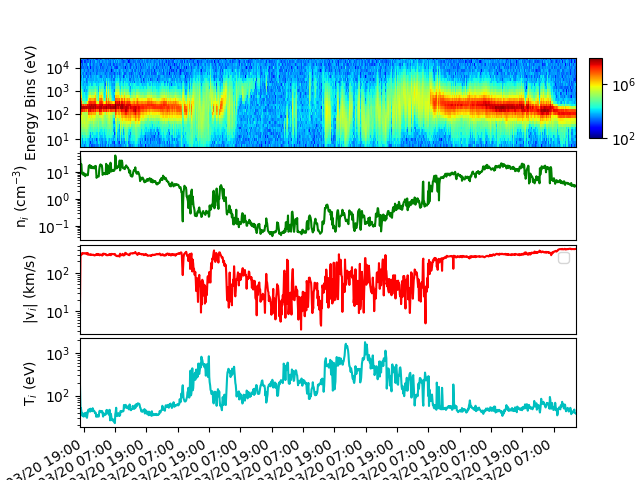

{'times': array(['2020-03-05T17:36:24.904400896', '2020-03-05T17:47:52.099168256',
        '2020-03-05T17:57:01.854982144', ...,
        '2020-03-13T15:16:21.625249792', '2020-03-13T15:27:48.820017152',
        '2020-03-13T15:36:58.575831040'], dtype='datetime64[ns]'),
 'times_original_type': 'Tensor',
 'ion_eflux_original_type': 'Tensor',
 'ion_eflux': array([[ 37982.297 ,  75165.16  , 119272.38  , ..., 237233.1   ,
          74294.79  ,  30972.938 ],
        [  9432.943 ,   8439.945 ,   6516.0317, ...,   1405.2842,
           2319.0403,   5960.37  ],
        [ 14554.691 ,   7853.2773,   8541.634 , ...,   3428.705 ,
           3626.48  ,   3049.2007],
        ...,
        [  3960.5493,   1292.1677,   8154.65  , ...,   3090.6345,
           3134.6724,   3259.3687],
        [  3399.9644,   3877.6165,   8049.7095, ...,   3627.6187,
           2352.4612,   2965.5679],
        [  1105.5099,   7133.635 ,   4803.464 , ...,   3686.704 ,
           2165.5317,   1415.3936]], dtype=float32),
 'i

In [22]:
plot_variables_from_sections(section=generation_samples_B['section_000'], variables=['ion_eflux', 'ion_density', 'ion_velocity_magnitude', 'ion_avgtemp'])

In [2]:
orbit_start_str_C = []
orbit_end_str_C = []


In [3]:

from tqdm import tqdm

# Define starting and ending year/month
start_year = 2023
start_month = 12
end_year = 2025
end_month = 6

dataset = 'THC_OR_SSC (2007-02-24 to 2025-08-31)'

def retry_request(func, tries=10, delay=2):
    """Retry a network call a few times before failing."""
    for attempt in range(tries):
        try:
            return func()
        except (ConnectionError, RemoteDisconnected) as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            if attempt == tries - 1:
                raise
            time.sleep(delay)

current_start = np.datetime64(f"2017-02-05")
current_end = current_start + np.timedelta64(20, 'D')

# Process each period from the approximate data
with tqdm(desc="Finding orbital periods") as pbar:
    while current_start <= np.datetime64(f"{end_year}-{end_month:02d}-01"):
        with silence_all():

            current_start_str = str(current_start)[:10]
            current_end_str = str(current_end)[:10]

            # Get files for this period
            urllist = retry_request(lambda: cdaweb_obj.get_filenames([dataset], current_start_str, current_end_str))
            retry_request(lambda: cdaweb_obj.cda_download(urllist, "cdaweb/"))
            
            true_data = get_data('XYZ_GSM')
            period_times = true_data.times
            period_pos = true_data.y
            
            # Apply time mask for this period
            time_mask = ((period_times*1e9).astype('datetime64[ns]') >= current_start) & ((period_times*1e9).astype('datetime64[ns]') <= current_end)
            period_times = period_times[time_mask]
            period_pos = period_pos[time_mask]
            
            # Apply spatial condition mask (nightside, -40 to 40 Re)
            spatial_mask = (period_pos[:, 1] >= -40) & (period_pos[:, 1] <= 40) & (period_pos[:, 0] <= -40)
            filtered_times = period_times[spatial_mask]
            
            if len(filtered_times) > 0:
                # Convert to datetime64 for easier manipulation
                filtered_times_dt = (filtered_times*1e9).astype('datetime64[ns]')
                
                # Get first entry and last exit for this period
                first_entry = filtered_times_dt[0]
                last_exit = filtered_times_dt[-1]
                
                # Add this period to our lists
                orbit_start_str_C.append(str(first_entry))
                orbit_end_str_C.append(str(last_exit))

            
        # Move to next period (advance by 25 days from first entry)
        pbar.update(1)
        pbar.set_postfix({"Periods found": len(orbit_start_str_C), "Current Start": str(current_start)[:10], "Current End": str(current_end)[:10]})
        
        current_end = first_entry + np.timedelta64(45, 'D')
        current_start = first_entry + np.timedelta64(25, 'D')

Finding orbital periods: 93it [05:32,  3.57s/it, Periods found=93, Current Start=2024-07-13, Current End=2024-08-02]


KeyboardInterrupt: 

In [8]:
orbit_start_str_C[-9]

'2023-11-23T21:46:00.000000000'

In [9]:
# Add magnetosheath parts from before magnetotail entries
for i in tqdm(range(len(orbit_start_str_C[:-9]))):
  try:  
    with silence_all():

      curr_data_class = LoadArtemis(start_time = orbit_start_str_C[i], 
                                    end_time   = orbit_end_str_C[i],
                                    satellite_list = ['THC']
                                      )

      curr_data_class.convert_min_delta_all(  start_time        = orbit_start_str_C[i],
                                              end_time          =  orbit_end_str_C[i],
                                              dt_method         ='max', 
                                              custom_time_delta = 600)

      curr_data_class.extract_to_HDF5('generation_data/artemis_P2_full.h5')
  except Exception as e:
    print(f"Error processing index {i}: {e}")
    continue

 67%|██████▋   | 56/84 [16:45<08:33, 18.36s/it]

Error processing index 55: list index out of range


100%|██████████| 84/84 [26:14<00:00, 18.75s/it]


In [ ]:
orbit_start_str_2 = []
orbit_end_str_2 = []

from tqdm import tqdm

# Define starting and ending year/month
start_year = 2013
start_month = 8
end_year = 2024
end_month = 12

%matplotlib inline

# Generate monthly periods
current_year = start_year
current_month = start_month

# Calculate total number of months for progress bar
total_months = 0
temp_year = start_year
temp_month = start_month
while (temp_year < end_year) or (temp_year == end_year and temp_month <= end_month):
    total_months += 1
    temp_month += 1
    if temp_month > 12:
        temp_month = 1
        temp_year += 1

# Reset to original values
current_year = start_year
current_month = start_month

with tqdm(total=total_months, desc="Processing months") as pbar:
    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        with silence_all():
            # Create start and end times for the month
            start_time = f"{current_year}-{current_month:02d}-01T00:00:00"
            
            # Calculate next month for end time
            next_month = current_month + 1
            next_year = current_year
            if next_month > 12:
                next_month = 1
                next_year += 1
            
            end_time = f"{next_year}-{next_month:02d}-01T00:00:00"

            dataset = 'THC_OR_SSC (2007-02-24 to 2025-08-31)'

            # Get the list of files for the specified time range
            urllist = cdaweb_obj.get_filenames([dataset], start_time, end_time)
            cdaweb_obj.cda_download(urllist, "cdaweb/")

            true_data = get_data('XYZ_GSM')

            true_data_times = true_data.times
            true_data_pos = true_data.y

            # Create a mask based on start and end times
            mask = ((true_data_times*1e9).astype('datetime64[ns]') >= np.datetime64(start_time)) & ((true_data_times*1e9).astype('datetime64[ns]') < np.datetime64(end_time))
            true_data_times = true_data_times[mask]
            true_data_pos = true_data_pos[mask]

            # Find when the spacecraft is within -40 to 40 Re in y
            mask_y = (true_data_pos[:, 1] >= -40) & (true_data_pos[:, 1] <= 40) & (true_data_pos[:, 0] <= 0)  # Also ensure x <= 0 to avoid dayside

            # Check if data points were removed from both ends to ensure all data between -40 and 40 is used
            initial_count = len(true_data_pos)
            filtered_count = np.sum(mask_y)
            removed_count = initial_count - filtered_count
            
            true_data_times = true_data_times[mask_y]
            true_data_pos = true_data_pos[mask_y]

            # Get first and last time
            start_time_actual = str((true_data_times[0]*1e9).astype('datetime64[ns]'))
            end_time_actual = str((true_data_times[-1]*1e9).astype('datetime64[ns]'))
            print(f"Start time: {start_time_actual}, End time: {end_time_actual}")

            orbit_start_str.append(start_time_actual)
            orbit_end_str.append(end_time_actual)
        
        # Move to next month
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
        
        pbar.update(1)
        pbar.set_postfix({"Year": current_year, "Month": current_month})


Processing months:   0%|          | 0/137 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Add magnetosheath parts from before magnetotail entries
for i in tqdm(range(len(orbit_start_str_2))):
    with silence_all():

      curr_data_class = LoadArtemis(start_time = orbit_start_str_2[i], 
                                    end_time   = orbit_end_str_2[i],
                                    satellite_list=['THC']
                                      )

      curr_data_class.convert_min_delta_all(start_time        = orbit_start_str_2[i],
                                              end_time          =  orbit_end_str_2[i],
                                              dt_method         ='max', 
                                              custom_time_delta = 600)

      curr_data_class.extract_to_HDF5('generation_data/artemis_P1_future_all.h5')